### LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

from pandas_dq import dq_report, Fix_DQ
from datetime import datetime
from IPython.display import display, HTML, display_html
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from fbprophet import Prophet

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

Imported pandas_dq (1.9). Always upgrade to get latest version.



/var/folders/dk/whmh7n016n59y33jb395nq1c0000gn/T/ipykernel_35094/266290580.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### EDA

In [2]:
df = pd.read_csv('municipality_bus_utilization.csv')
dq_report(df,verbose = 1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
timestamp,object,0.000000,10,2017-06-04 07:59:42,2017-08-19 16:30:35,"1309 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 1309 unique values: Use hash encoding or embedding to reduce dimension."
municipality_id,int64,0.000000,0,0,9,No issue
usage,int64,0.000000,17,11,3508,has 734 outliers greater than upper bound (2370.5) or lower than lower bound(-777.5). Cap them or remove them.
total_capacity,int64,0.000000,0,397,3893,No issue


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
timestamp,object,0.0000,10,2017-06-04 07:59:42,2017-08-19 16:30:35,1309 rare categories: Too many to list. Group ...
municipality_id,int64,0.0000,0,0,9,No issue
usage,int64,0.0000,17,11,3508,has 734 outliers greater than upper bound (237...
total_capacity,int64,0.0000,0,397,3893,No issue


In [3]:
# Rapor incelendiğinde 10 unique tarih değerinin yani saat 07 - 16 arasında olduğuna varılır.
# Misiing values olmadığı görülüyor fakat veri incelendiğinde bazı municipalitylerde eksik tarihlerin buna bağlı olarak eksik kullanımların olduğu tespiti yapıldı.

In [4]:
profiling = ProfileReport(df)
profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# It has been observed that the usage data is right skewed.
# The data is concentrated more on low usage.
# Since there are no negative values and it exhibits an exponential distribution, a Boxplot transformation can be applied.
# However, as only future predictions and error terms are required, no transformation has been applied.
# Additionally, distributions provide information about municipalities. In this case, it can be decided that usage should increase based solely on the visual, as a cost decision.

### Arrange Data Time and Group By 

In [6]:
# Conversion from object to date format
df['timestamp'] = pd.to_datetime(df['timestamp'])
# extract time column create to hour column
df['hour'] = df['timestamp'].dt.hour
# extract time column create to date column
date = df['date'] = df['timestamp'].dt.date

### According One Hour Max Values of Group 

In [7]:
df['timestamp'] = df['timestamp'].apply(lambda x: x.replace(minute=0, second=0))

df = df[['timestamp', 'municipality_id','usage','total_capacity']]

In [8]:
start_date = dt.date(2017, 6, 4)
end_date = dt.date(2017, 8, 19)

# Generating the timestamps for each day from 7am to 16
timestamps = []
for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    for hour in range(7, 17):
        timestamp = dt.datetime.combine(date, dt.time(hour=hour))
        timestamps.append(timestamp)

In [9]:
# Create a new dataframe with all combinations of municipality IDs and datetime values
new_index = pd.MultiIndex.from_product([range(10), timestamps], names=["municipality_id", "timestamp"])
new_df = pd.DataFrame(index=new_index).reset_index()

# Merge with the original dataframe to fill missing values
merged_df = pd.merge(new_df, df, on=["municipality_id", "timestamp"], how="left")

print("######################### isnull #########################")
print(merged_df.isnull().sum())
print("######################### head #########################")
print(merged_df.head(25))

######################### isnull #########################
municipality_id      0
timestamp            0
usage              960
total_capacity     960
dtype: int64
######################### head #########################
    municipality_id           timestamp    usage  total_capacity
0                 0 2017-06-04 07:00:00 204.0000       2813.0000
1                 0 2017-06-04 08:00:00 247.0000       2813.0000
2                 0 2017-06-04 08:00:00 332.0000       2813.0000
3                 0 2017-06-04 09:00:00 429.0000       2813.0000
4                 0 2017-06-04 09:00:00 485.0000       2813.0000
5                 0 2017-06-04 10:00:00 534.0000       2813.0000
6                 0 2017-06-04 10:00:00 583.0000       2813.0000
7                 0 2017-06-04 11:00:00 597.0000       2813.0000
8                 0 2017-06-04 11:00:00 614.0000       2813.0000
9                 0 2017-06-04 12:00:00 613.0000       2813.0000
10                0 2017-06-04 13:00:00 605.0000       2813.0000

### Missing Values Analysis

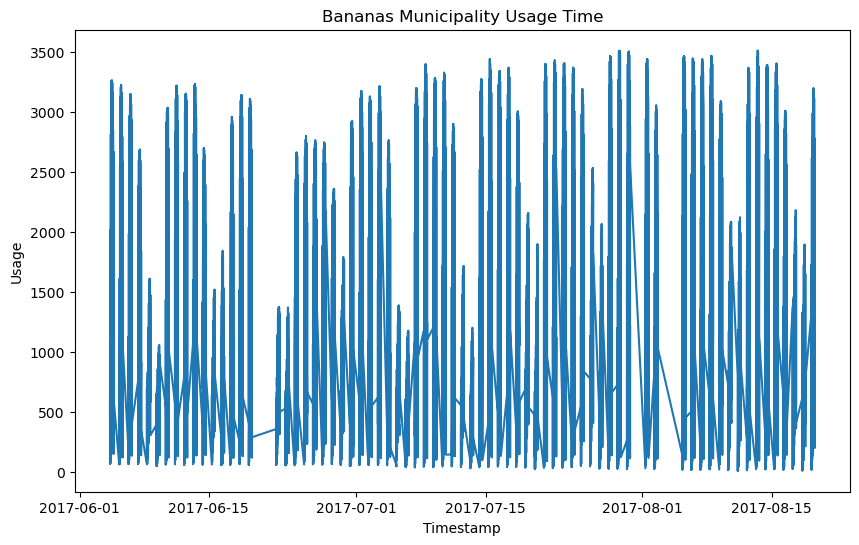

In [10]:
%matplotlib inline

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df['timestamp'], df['usage'])

# Set the axis labels and title
plt.xlabel('Timestamp')
plt.ylabel('Usage')
plt.title('Bananas Municipality Usage Time')

# Show the plot
plt.show()


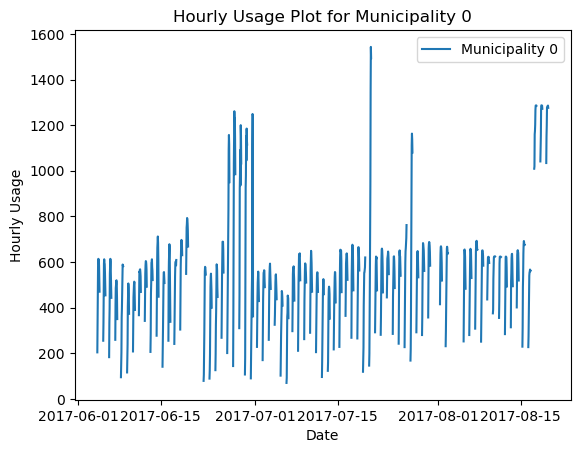

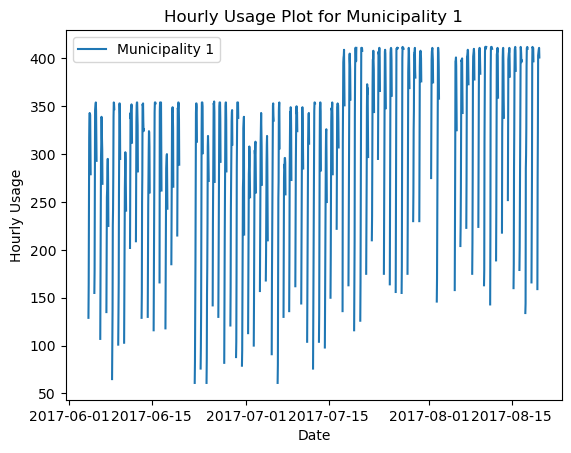

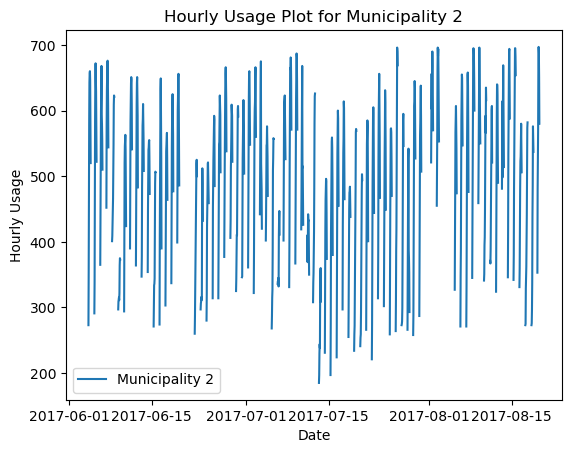

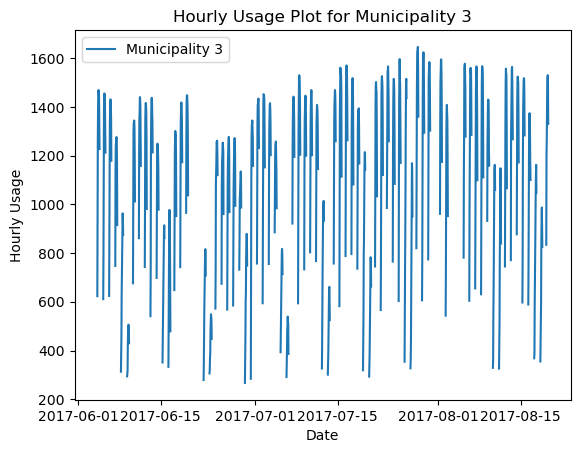

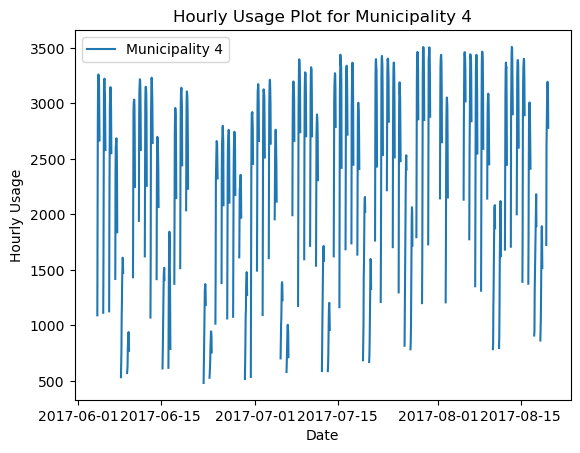

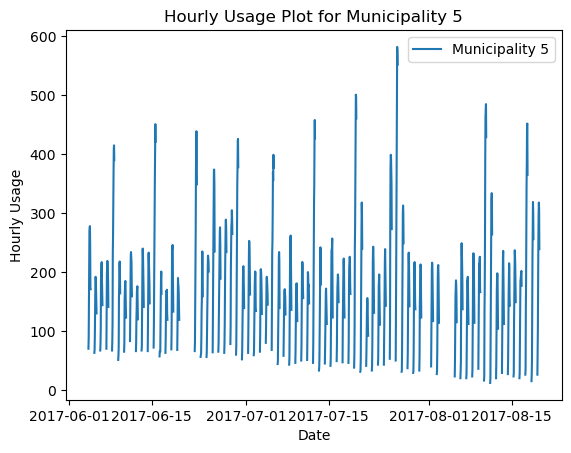

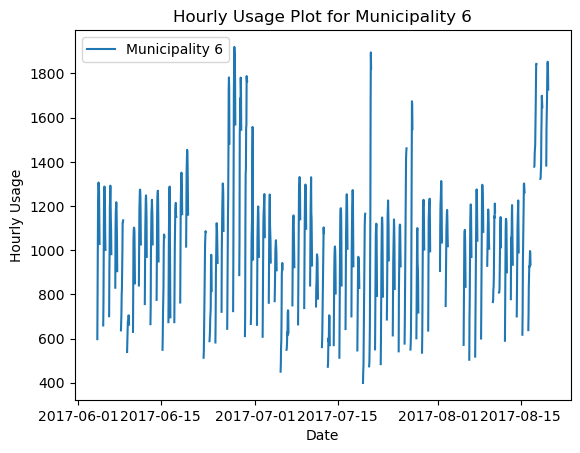

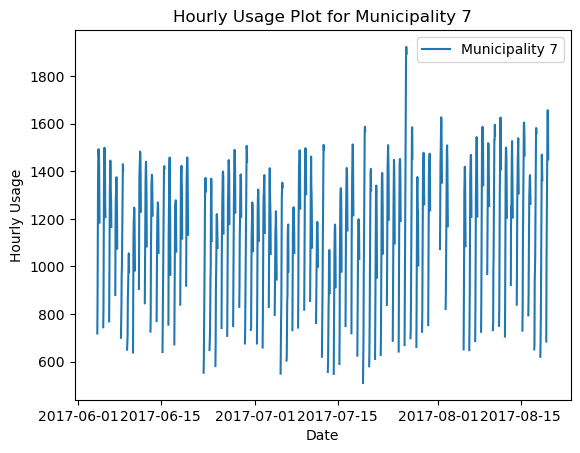

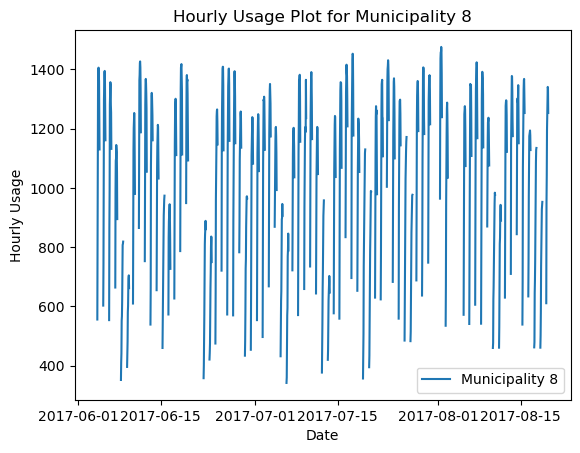

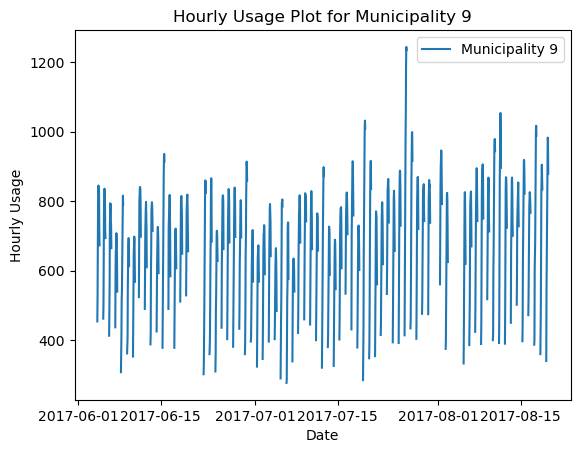

In [11]:
#For each Municipality plot
%matplotlib inline
for i in range(10):
    df_m = merged_df[merged_df['municipality_id'] == i]
    df_m = df_m.set_index('timestamp')
    df_m = df_m.resample('1H').max() # Resample to hourly data
    plt.plot(df_m.index, df_m['usage'], label='Municipality {}'.format(i))
    plt.xlabel('Date')
    plt.ylabel('Hourly Usage')
    plt.title('Hourly Usage Plot for Municipality {}'.format(i))
    plt.legend()
    plt.show()

In [12]:
# Each municipality has a different usage distribution, and they are not linearly distributed, 
# so instead of linear or simple interpolations, filling methods for skewed distributions will be used.

### Filling Missing Values

In [13]:
# Create a summary table to show the number of missing values for each municipality
summary = merged_df.groupby(['municipality_id'])['usage'].apply(lambda x: x.isnull().sum()).reset_index(name='Missing values')
#print(summary)
# Loop through each municipality and fill in missing values using moving average
for muni in merged_df['municipality_id'].unique():
    muni_df = merged_df[merged_df['municipality_id'] == muni]
    missing = muni_df['usage'].isnull().sum()
    
    if missing > 0:
        # Calculate moving average with window size of 10
        # Important!! Since hourly data is used, it would be more appropriate to set the moving average parameter to 10
        # The imputation process has been applied separately for each municipality.  
        muni_df['usage'] = muni_df['usage'].rolling(window=10, min_periods=1, center=True).mean()
        
        # Replace any remaining missing values with the mean
        muni_df['usage'].fillna(muni_df['usage'].mean(), inplace=True)
        
        # Update the original dataframe with the filled-in values
        merged_df.loc[merged_df['municipality_id'] == muni, 'usage'] = muni_df['usage']
        merged_df = merged_df[['municipality_id','timestamp','usage']]

### Filling Values Analysis

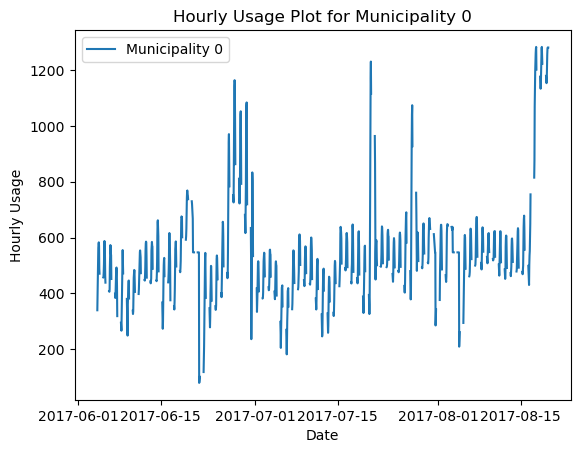

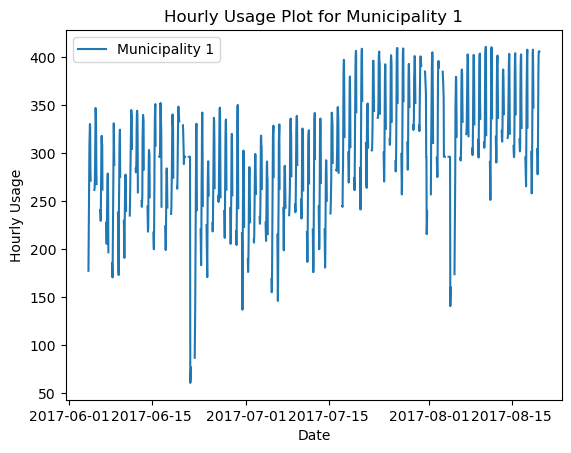

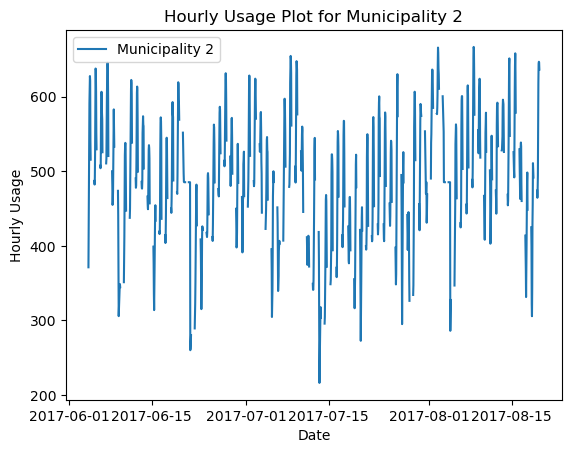

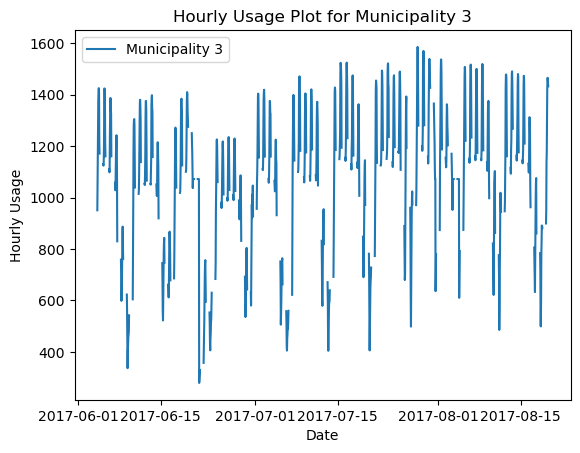

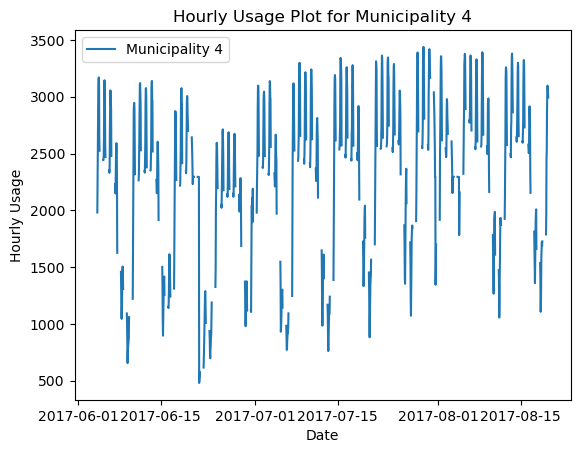

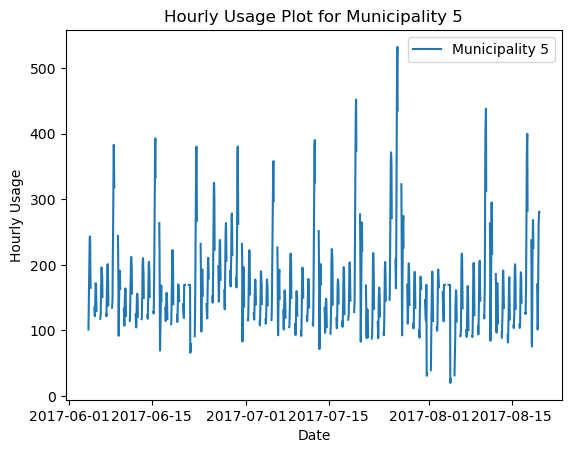

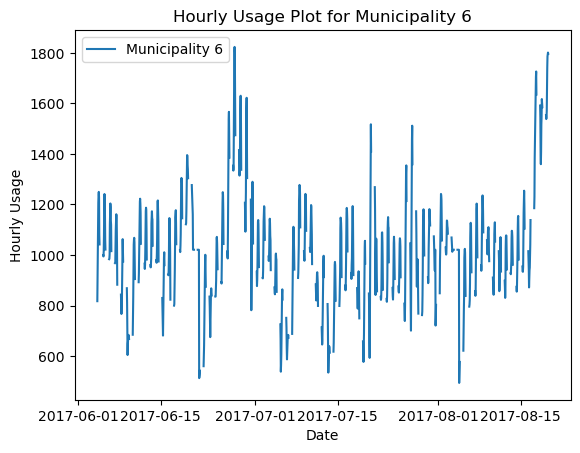

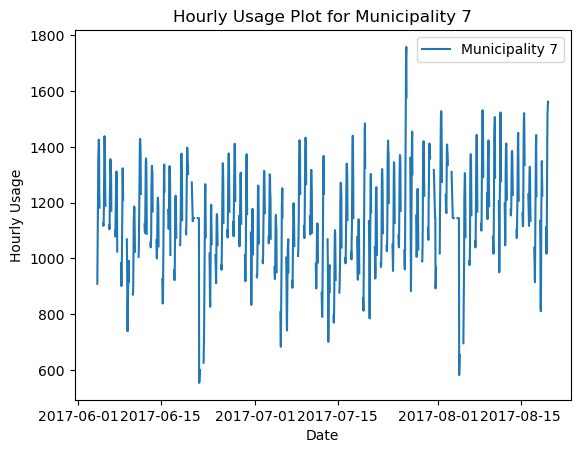

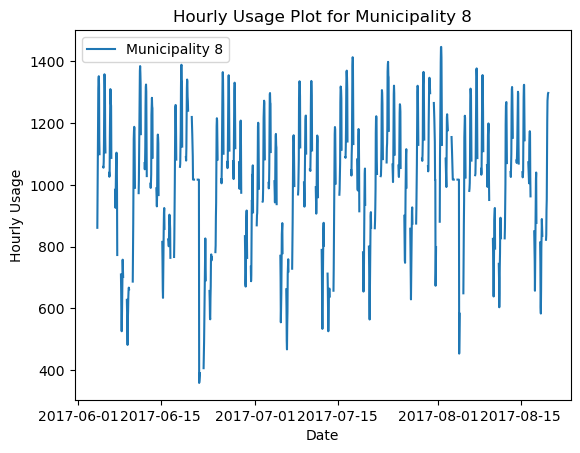

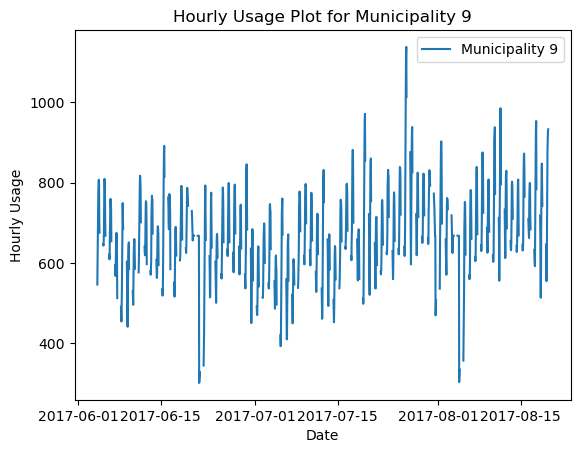

In [14]:
%matplotlib inline
for i in range(10):
    df_m = merged_df[merged_df['municipality_id'] == i]
    df_m = df_m.set_index('timestamp')
    df_m = df_m.resample('1H').max() # Resample to hourly data
    plt.plot(df_m.index, df_m['usage'], label='Municipality {}'.format(i))
    plt.xlabel('Date')
    plt.ylabel('Hourly Usage')
    plt.title('Hourly Usage Plot for Municipality {}'.format(i))
    plt.legend()
    plt.show()

In [15]:
### After imputation, statistical descriptions were examined once again for each municipality. It was determined that the values had less skewness.
grouped = merged_df.groupby("municipality_id")
stats = grouped['usage'].describe()
stats
print("######################### stats describe #########################")
print(stats)
grouped = df.groupby("municipality_id")
stats1 = grouped['usage'].describe()
stats1
print("######################### stats1 describe #########################")
print(stats1)

######################### stats describe #########################
                    count      mean      std      min       25%       50%       75%       max
municipality_id                                                                              
0               1403.0000  546.8922 199.1486  79.0000  441.4444  516.0000  603.8500 1283.2000
1               1403.0000  296.5940  64.0837  61.0000  255.7000  297.1000  339.6667  411.0000
2               1403.0000  485.3247  88.3762 213.6667  424.2222  488.5000  551.2000  666.8000
3               1403.0000 1072.2112 295.8232 279.0000  887.1000 1129.3333 1300.7000 1586.1000
4               1403.0000 2294.7390 730.7068 481.0000 1771.3333 2477.6667 2859.6500 3438.3000
5               1403.0000  169.5668  70.7002  20.0000  122.0500  158.0000  193.0500  532.4444
6               1403.0000 1020.9010 228.2590 494.0000  881.0500 1008.8889 1135.9000 1823.4000
7               1403.0000 1144.2717 184.2489 553.0000 1022.4444 1144.2717 1284.1611 175

### According Municipality Hourly Max Values Group

In [16]:
df_max = merged_df.groupby(['municipality_id', pd.Grouper(key='timestamp',freq='1H')])['usage'].max().reset_index()
df_max.head()

,municipality_id,timestamp,usage
0,0,2017-06-04 07:00:00,339.4000
1,0,2017-06-04 08:00:00,402.0000
2,0,2017-06-04 09:00:00,447.2222
3,0,2017-06-04 10:00:00,503.9000
4,0,2017-06-04 11:00:00,563.5000


### SIMPLE MODEL EXPONENTIALSMOOTHING

In [17]:
test_start = datetime(2017, 8, 5)
test_end = datetime(2017, 8, 19)
train = df_max[df_max['timestamp'] < test_start]
test = df_max[(df_max['timestamp'] >= test_start) & (df_max['timestamp'] <= test_end)]

In [18]:
# Exponential Smoothing modelini oluşturma
def exp_smoothing_model(train, test, alpha=0.2, beta=0.2, trend='add', seasonal=None):
    # Modeli eğitme
    model = ExponentialSmoothing(train['usage'], trend=trend, seasonal=seasonal)
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta)

    # Modeli kullanarak test verisi üzerinde tahmin yapma
    forecast = model_fit.forecast(len(test))

    # Tahminleri ve gerçek değerleri birleştirme
    forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])
    results = pd.concat([forecast, test['usage']], axis=1)

    # Hata hesaplama
    error = ((results['Prediction'] - results['usage']) ** 2).mean()

    return results, error

# Modeli kullanarak tahminler yapma
results, error = exp_smoothing_model(train, test)
error

805337338.984131

### COMPLEX MODEL SELECT

In [19]:
df_max_final = df_max.copy()
df_max_final = pd.DataFrame(df_max_final)
df_max_final = df_max_final.groupby("municipality_id")

train_set = pd.DataFrame(columns=["municipality_id", "timestamp", "usage"])
test_set = pd.DataFrame(columns=["municipality_id", "timestamp", "usage"])

for group_name, group_data in df_max_final:
    train, test = train_test_split(group_data, test_size=0.2, shuffle=False)

    train_end = train["timestamp"].max()
    train_start = train_end - pd.Timedelta(days=7)
    train = train[train["timestamp"].between(train_start, train_end)]
    
    test_end = test["timestamp"].max()
    test_start = test_end - pd.Timedelta(days=14)
    test = test[test["timestamp"].between(test_start, test_end)]

    train_set = pd.concat([train_set, train])
    test_set = pd.concat([test_set, test])

    features = ["municipality_id", "usage"]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    rf.fit(train_set[features], train_set["usage"])

    predictions = rf.predict(test_set[features])

    error = mean_squared_error(test_set["usage"], predictions)

print("Mean squared error:", error)


Mean squared error: 76.0015250406272


In [20]:
# A model with random forest algorithm resulted in lower error compared to the Exponential Smoothing model.
# Shuffling the last two weeks of test data resulted in better performance

### Each Municipality Complex Model 

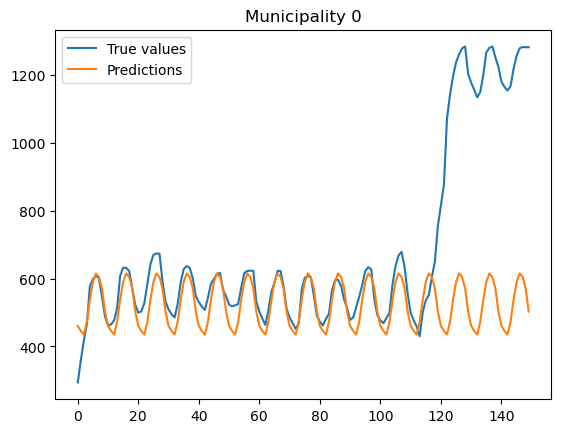

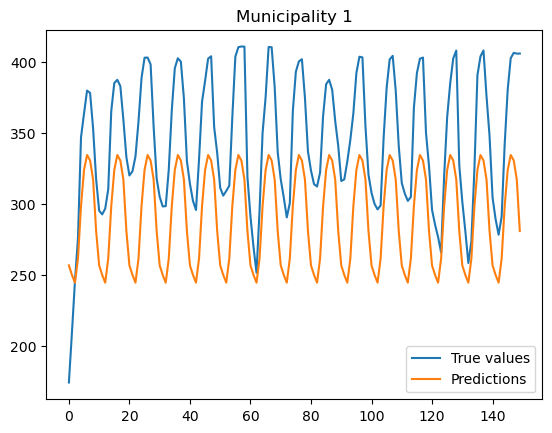

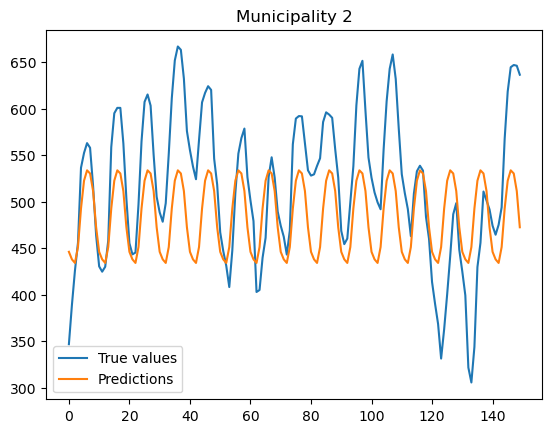

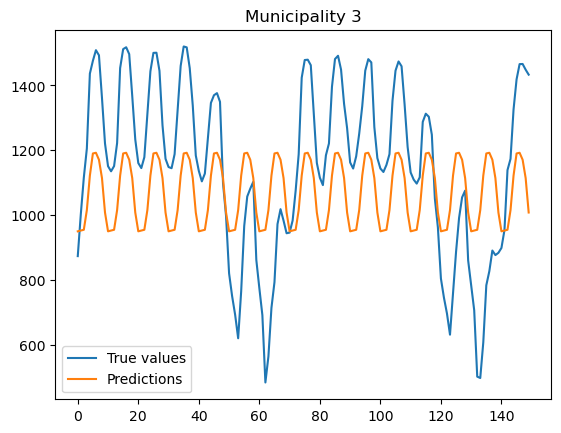

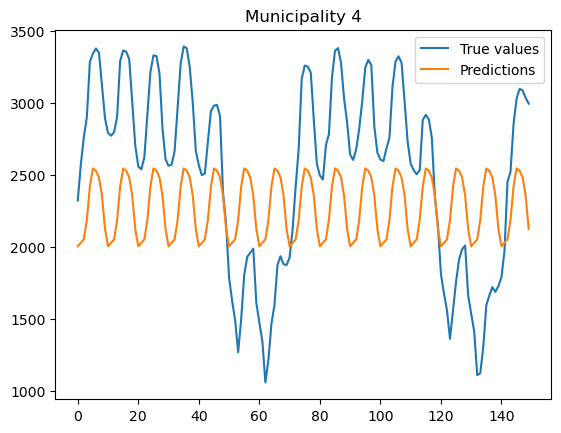

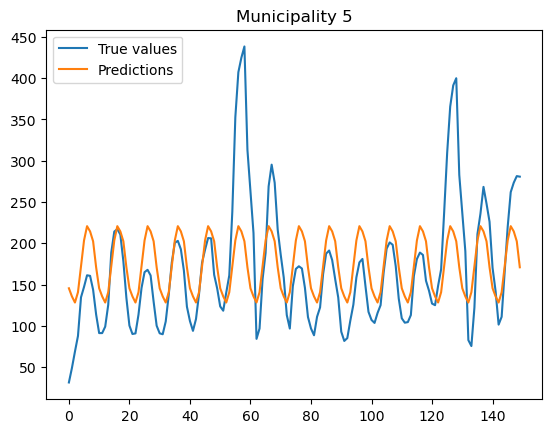

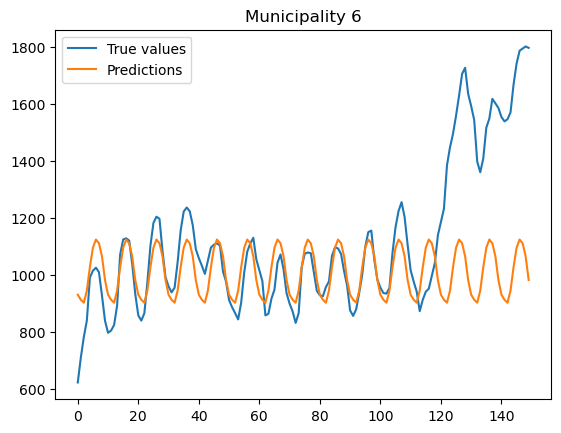

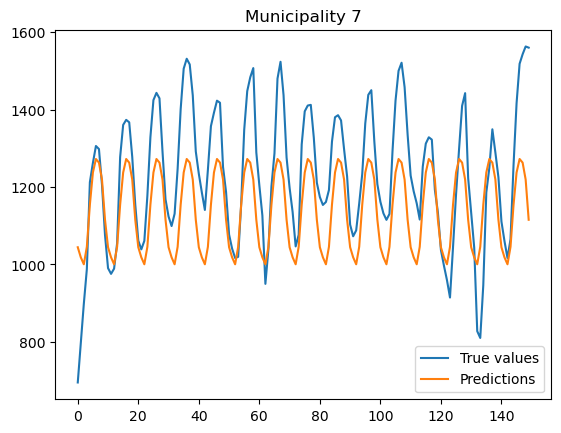

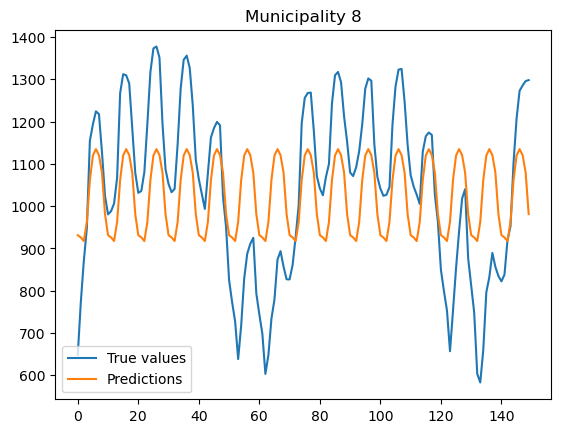

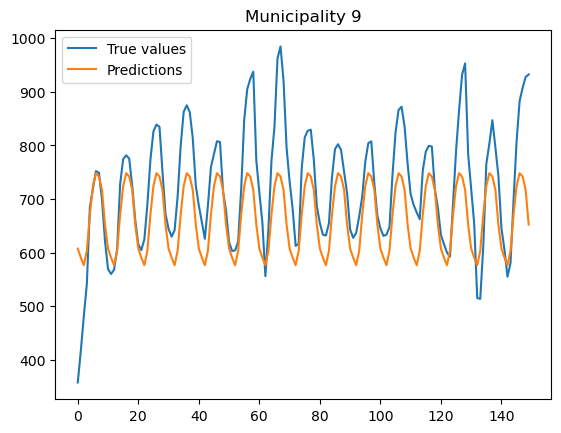

Total MAE: 166.49123797036657


In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

mae_list = []
for muni_id in range(10):
    data_muni = df_max[df_max['municipality_id'] == muni_id]

    data_muni['date'] = data_muni['timestamp'].dt.date
    data_muni['hour'] = data_muni['timestamp'].dt.hour

    train_data = data_muni[data_muni['timestamp'] < '2017-08-05']
    # Split dataset into training and test sets
    test_data = data_muni[data_muni['timestamp'] >= '2017-08-05']

    X_train = train_data['hour'].values.reshape(-1, 1)
    y_train = train_data['usage'].values

    rf_model.fit(X_train, y_train)

    X_test = test_data['hour'].values.reshape(-1, 1)
    y_test = test_data['usage'].values
    y_pred = rf_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

    plt.plot(y_test, label='True values')
    plt.plot(y_pred, label='Predictions')
    plt.title(f'Municipality {muni_id}')
    plt.legend()
    plt.show()

total_mae = sum(mae_list) / len(mae_list)
print(f'Total MAE: {total_mae}')

### Prophet MODEL

In [ ]:
# Split the data into train and test sets
train = df_max[df_max['timestamp'] < "2017-08-05"]
test = df_max[df_max['timestamp'] >= "2017-08-05"]

# Create a Prophet model for each municipality
models = {}
for muni_id in range(10):
    # Filter the data for the municipality
    muni_data = train[train['municipality_id'] == muni_id][['timestamp', 'usage']]
    muni_data = muni_data.rename(columns={'timestamp': 'ds', 'usage': 'y'})
    
    # Create and fit the model
    model = Prophet()
    model.fit(muni_data)
    models[muni_id] = model

# Forecast for the next week
forecast = pd.DataFrame()
for muni_id in range(10):
    # Create the future dataframe
    future = models[muni_id].make_future_dataframe(periods=7*10, freq="H", include_history=False)
    
    # Make the forecast
    forecast_muni = models[muni_id].predict(future)
    forecast_muni['municipality_id'] = muni_id
    
    # Add the forecast to the final dataframe
    forecast = pd.concat([forecast, forecast_muni])

# Merge the forecast with the test set and calculate the error
test_with_forecast = pd.merge(test, forecast, on=['municipality_id', 'ds'])
error = ((test_with_forecast['usage'] - test_with_forecast['yhat'])**2).mean()

# Print the error
print("MSE for the last two weeks: ", error)

In [ ]:
# The prophet model was tested on the server.
#The mae value was 133.3891.

In [ ]:
# During the experimentation of simple and complex models for each municipality, the total error rates were calculated for the desired test periods and data preprocessing steps. 
# The best results were obtained from Random Forest model.